In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import norm
from scipy import stats

In [3]:
batch_size = 4000

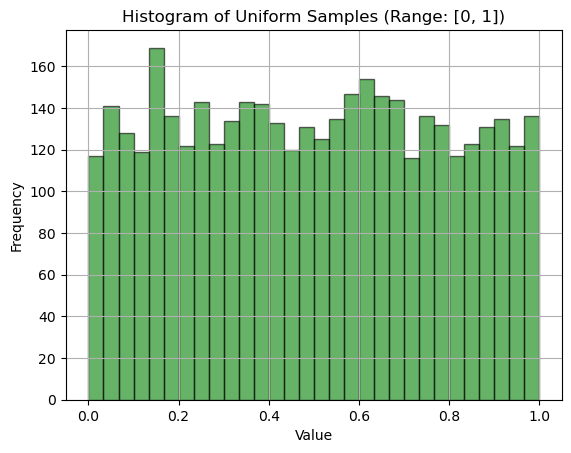

In [4]:
# Generate uniform samples
uniform_samples = np.random.uniform(low=0, high=1, size=batch_size).astype(np.float32)
uniform_samples_tensor = torch.tensor(uniform_samples).unsqueeze(1)

# Plot histogram of uniform samples
plt.hist(uniform_samples, bins=30, alpha=0.6, color='green', edgecolor='black')
plt.title('Histogram of Uniform Samples (Range: [0, 1])')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

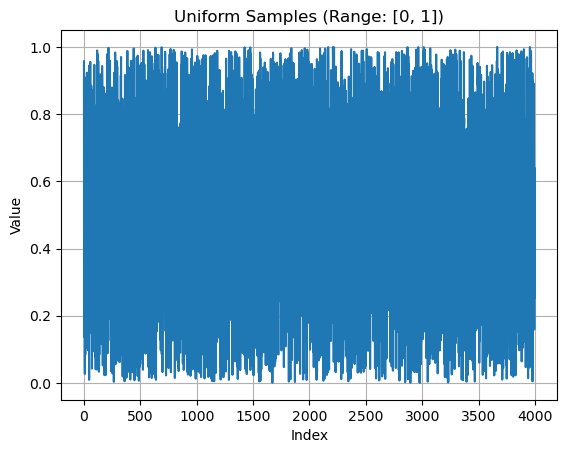

In [5]:
# Plot uniform samples trace
plt.plot(uniform_samples)
plt.title('Uniform Samples (Range: [0, 1])')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

/opt/spack/opt/spack/linux-rhel8-icelake/gcc-12.2.0/anaconda3-2023.09-0-cnhkdqo23hjp6vajx75rg2skgd46qyjv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


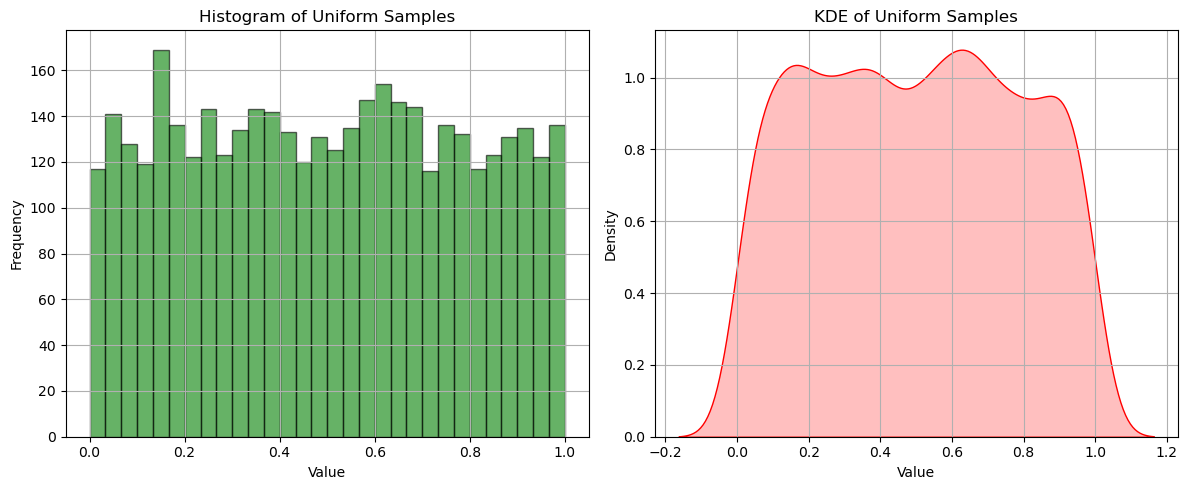

In [6]:
# Plot histogram and KDE side by side
plt.figure(figsize=(12, 5))
# Subplot 1: Histogram
plt.subplot(1, 2, 1)
plt.hist(uniform_samples, bins=30, alpha=0.6, color='green', edgecolor='black')
plt.title('Histogram of Uniform Samples')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
# Subplot 2: KDE
plt.subplot(1, 2, 2)
sns.kdeplot(uniform_samples, color='red', fill=True)
plt.title('KDE of Uniform Samples')
plt.xlabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
# Define PDF functions for acceptance-rejection method
def normal_pdf(x, mean=0, std=1):
    return (1 / (std * np.sqrt(2 * np.pi))) * torch.exp(-0.5 * ((x - mean) / std) ** 2)

In [8]:
def proposal_pdf(x, a=2.5):
    # Uniform proposal distribution PDF on [-a, a]
    mask = (x >= -a) & (x <= a)
    return mask.float() * (1 / (2 * a))

In [9]:
def compute_mean(samples):
    return torch.mean(samples)

In [10]:
def compute_variance(samples):
    return torch.var(samples)

In [11]:
def compute_skewness(samples):
    mean = compute_mean(samples)
    variance = compute_variance(samples)
    skewness = torch.mean(((samples - mean) ** 3)) / (variance ** 1.5)
    return skewness

In [12]:
def compute_kurtosis(samples):
    mean = compute_mean(samples)
    variance = compute_variance(samples)
    kurtosis = torch.mean(((samples - mean) ** 4)) / (variance ** 2) - 3
    return kurtosis

In [13]:
# Acceptance-rejection sampling
# Params
M = 2.1  # Scaling factor for proposal 
a = 2.5  # Range for uniform proposal: [-a, a]
num_samples = batch_size
max_iterations = 100000
device = "cpu"

accepted_samples = torch.zeros(num_samples, 1).to(device)
accepted_count = 0
total_iterations = 0

start_time = time.time()

while accepted_count < num_samples and total_iterations < max_iterations:
    # Generate proposal samples from U(0,1)
    proposal_batch_size = min(batch_size, num_samples - accepted_count)
    uni_input = np.random.uniform(low=0, high=1, size=proposal_batch_size).astype(np.float32)
    uni_input = torch.tensor(uni_input).unsqueeze(1).to(device)
    # Transform to U(-a, a)
    proposal_samples = 2 * a * uni_input - a
    
    # Generate uniform samples for acceptance test
    uni_acceptance = np.random.uniform(low=0, high=1, size=proposal_batch_size).astype(np.float32)
    uni_acceptance = torch.tensor(uni_acceptance).unsqueeze(1).to(device)
    
    # Compute acceptance probability
    normal_density = normal_pdf(proposal_samples)
    proposal_density = proposal_pdf(proposal_samples, a)
    acceptance_ratio = normal_density / (M * proposal_density)
    
    # Accept samples onlhy when  uni_acceptance <= acceptance_ratio
    accept_mask = (uni_acceptance <= acceptance_ratio).squeeze()
    
    if accept_mask.sum() > 0:
        num_accepted_batch = min(accept_mask.sum().item(), num_samples - accepted_count)
        accepted_samples[accepted_count:accepted_count + num_accepted_batch] = proposal_samples[accept_mask][:num_accepted_batch]
        accepted_count += num_accepted_batch
    
    total_iterations += proposal_batch_size

elapsed_time = time.time() - start_time
efficiency = 100 * accepted_count / total_iterations

print(f"Rejection sampling completed in {elapsed_time:.5f} seconds.")
print(f"Generated {accepted_count} samples from {total_iterations} proposal samples.")
print(f"Acceptance efficiency: {efficiency:.2f}%")


Rejection sampling completed in 0.01725 seconds.
Generated 4000 samples from 8623 proposal samples.
Acceptance efficiency: 46.39%


In [14]:
mean_value = compute_mean(accepted_samples)
variance_value = compute_variance(accepted_samples)
skewness_value = compute_skewness(accepted_samples)
kurtosis_value = compute_kurtosis(accepted_samples)

print(f"Generated distribution moments:")
print(f"Mean: {mean_value.item():.4f} (target: 0)")
print(f"Variance: {variance_value.item():.4f} (target: 1)")
print(f"Skewness: {skewness_value.item():.4f} (target: 0)")
print(f"Kurtosis: {kurtosis_value.item():.4f} (target: 3)")


Generated distribution moments:
Mean: -0.0045 (target: 0)
Variance: 0.9045 (target: 1)
Skewness: -0.0490 (target: 0)
Kurtosis: -0.3701 (target: 3)


In [15]:
# Convert to numpy for plotting
normal_samples = accepted_samples.cpu().numpy()
normal_samples_flat = normal_samples.flatten()

/opt/spack/opt/spack/linux-rhel8-icelake/gcc-12.2.0/anaconda3-2023.09-0-cnhkdqo23hjp6vajx75rg2skgd46qyjv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


NameError: name 'x' is not defined

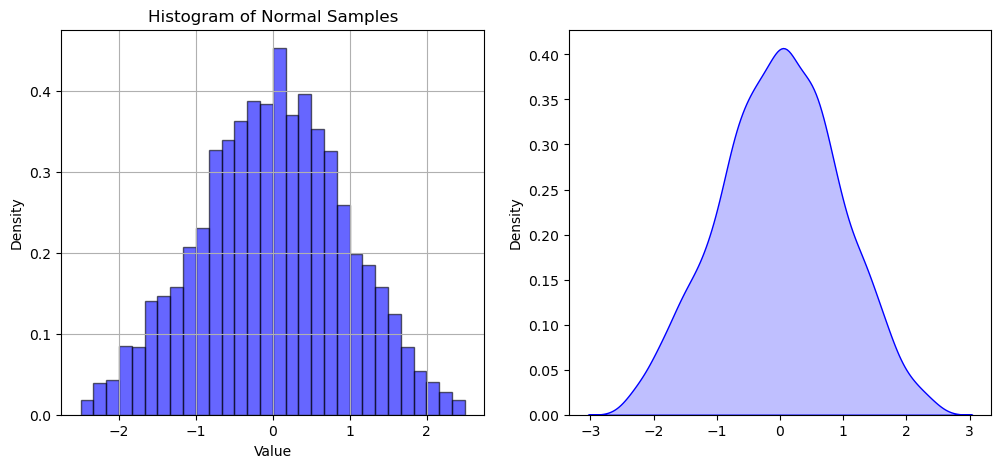

In [16]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(normal_samples_flat, bins=30, density=True, alpha=0.6, color='blue', edgecolor='black')
plt.title('Histogram of Normal Samples')
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.kdeplot(normal_samples_flat, color='blue', fill=True, label='Generated')
plt.plot(x, norm.pdf(x, 0, 1), 'r-', linewidth=2, label='True PDF')
plt.title('KDE of Normal Samples')
plt.xlabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Create Q-Q plot
plt.figure(figsize=(8, 8))

# sort
sorted_samples = np.sort(normal_samples_flat)


n = len(sorted_samples)
quantiles = np.arange(1, n + 1) / (n + 1)
theoretical_quantiles = norm.ppf(quantiles, 0, 1)

plt.scatter(theoretical_quantiles, sorted_samples, s=10, color='blue')
plt.plot([-4, 4], [-4, 4], 'r--', label='45° line')
plt.title('Q-Q Plot (Normal Distribution)')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()

In [ ]:

# Compare with scipy's normal distribution
scipy_normal = norm.rvs(size=batch_size)

# Plot comparison of distributions
plt.figure(figsize=(10, 6))
plt.hist(normal_samples_flat, bins=30, alpha=0.5, label='Acceptance-Rejection', density=True)
plt.hist(scipy_normal, bins=30, alpha=0.5, label='SciPy Normal', density=True)
plt.legend()
plt.title('Comparison of Normal Distributions')
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Print statistics comparison
print("Acceptance-Rejection Method:")
print(f"Mean: {np.mean(normal_samples_flat):.4f}")
print(f"Variance: {np.var(normal_samples_flat):.4f}")
print(f"Skewness: {stats.skew(normal_samples_flat):.4f}")
print(f"Kurtosis: {stats.kurtosis(normal_samples_flat):.4f}")

print("\nSciPy Normal:")
print(f"Mean: {np.mean(scipy_normal):.4f}")
print(f"Variance: {np.var(scipy_normal):.4f}")
print(f"Skewness: {stats.skew(scipy_normal):.4f}")
print(f"Kurtosis: {stats.kurtosis(scipy_normal):.4f}")